# Thermal Phase Shifter

1.


In [1]:
from collections import OrderedDict
import xarray as xr

import matplotlib.pyplot as plt
import numpy as np
from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.thermal import solve_thermal
from shapely.geometry import LineString, Polygon
from skfem import Basis, ElementTriP0
from femwell.visualization import plot_domains
from tqdm import tqdm
from skfem.io import from_meshio


2. 


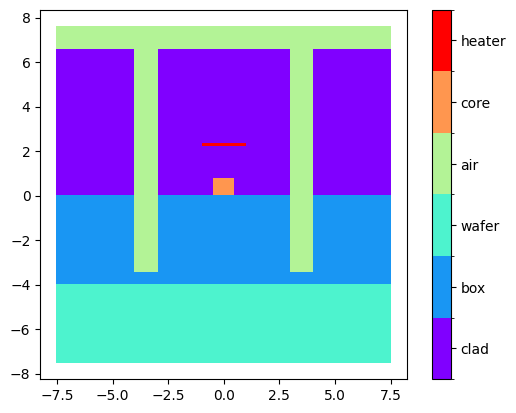

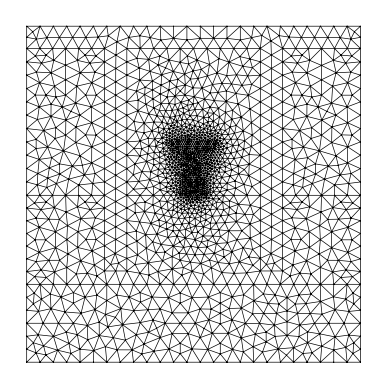

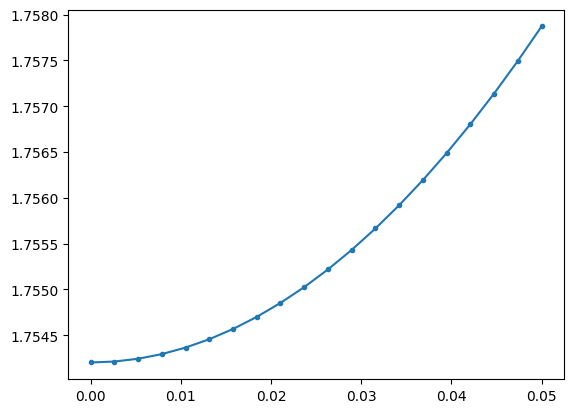

In [2]:

def simulate_heater(heater_width: float = 2.0,
                    wavelength: float = 1.55,
                    trench_w: float = 2,
                    trench_h: float = 10,
                    currents: float = 10e-3,
                    w_sim: float = 15,
                    plot: bool = False,
                    ):

    h_clad = 6.6
    h_box = 4
    w_core = 1
    h_core = 0.8
    h_heater = 0.2
    h_silicon = 3.5

    offset_heater = 1.7 + (h_core + h_heater) / 2

    trench_gap = 5 + w_core
    air_h = 1

    air=Polygon(
        [
            (-w_sim/2, h_clad),
            (-trench_gap/2-trench_w, h_clad),
            (-trench_gap/2-trench_w, h_clad-trench_h),
            (-trench_gap/2, h_clad-trench_h),
            (-trench_gap/2, h_clad),
            (trench_gap/2, h_clad),
            (trench_gap/2, h_clad-trench_h),
            (trench_gap/2+trench_w, h_clad-trench_h),
            (trench_gap/2+trench_w, h_clad),
            (w_sim/2, h_clad),
            (w_sim/2, h_clad+air_h),
            (-w_sim/2, h_clad+air_h),
            (-w_sim/2, h_clad),
        ]
    )

    polygons = OrderedDict(
        bottom=LineString(
            [
                (-w_sim / 2, -h_box - h_silicon),
                (w_sim / 2, -h_box - h_silicon),
            ]
        ),
        core=Polygon(
            [
                (-w_core / 2, 0),
                (-w_core / 2, h_core),
                (w_core / 2, h_core),
                (w_core / 2, 0),
            ]
        ),
        heater=Polygon(
            [
                (-heater_width / 2, offset_heater),
                (-heater_width / 2, h_heater + offset_heater),
                (heater_width / 2, h_heater + offset_heater),
                (heater_width / 2, offset_heater),
            ]
        ),
        clad=Polygon(
            [
                (-w_sim / 2, 0),
                (-w_sim / 2, h_clad),
                (w_sim / 2, h_clad),
                (w_sim / 2, 0),
            ]
        ).difference(air),
        box=Polygon(
            [
                (-w_sim / 2, 0),
                (-w_sim / 2, -h_box),
                (w_sim / 2, -h_box),
                (w_sim / 2, 0),
            ]
        ).difference(air),
        wafer=Polygon(
            [
                (-w_sim / 2, -h_box - h_silicon),
                (-w_sim / 2, -h_box),
                (w_sim / 2, -h_box),
                (w_sim / 2, -h_box - h_silicon),
            ],
        ).difference(air),
        air=air,

    )

    resolutions = {
        "core": {"resolution": 0.1, "distance": 1},
        "clad": {"resolution": 0.6, "distance": 1},
        "box": {"resolution": 0.6, "distance": 1},
        "air": {"resolution": 0.6, "distance": 1},
        "heater": {"resolution": 0.1, "distance": 1},
    }

    mesh = from_meshio(
        mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6)
    )

    current_densities = currents / polygons["heater"].area
    neffs = []

    basis0 = Basis(mesh, ElementTriP0(), intorder=4)
    thermal_conductivity_p0 = basis0.zeros()

    for domain, value in {
        "core": 18.5,
        "box": 1.38,
        "clad": 1.38,
        "heater": 173,
        "wafer": 150,
        "air": 0.026,
    }.items():
        thermal_conductivity_p0[basis0.get_dofs(elements=domain)] = value
    thermal_conductivity_p0 *= 1e-12

    if plot:
        plot_domains(mesh)
        mesh.draw().show()

    for current_density in current_densities:
        basis, temperature = solve_thermal(
            basis0,
            thermal_conductivity_p0,
            specific_conductivity={"heater": 1.8e7},
            current_densities={"heater": current_density},
            fixed_boundaries={"bottom": 0},
        )

        temperature0 = basis0.project(basis.interpolate(temperature))
        epsilon = basis0.zeros() + (1.45 + 8.66e-6 * temperature0) ** 2
        epsilon[basis0.get_dofs(elements="core")] = (
            1.97439 + 2.45e-5 * temperature0[basis0.get_dofs(elements="core")]
        ) ** 2

        modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=1, solver="scipy")
        neffs.append(np.real(modes[0].n_eff))

    return neffs


currents = np.linspace(0.0, 50e-3, 20)
n_eff = simulate_heater(currents=currents, trench_w=1, plot=True)

plt.plot(currents, n_eff, ".-")

Text(0, 0.5, 'n_eff')

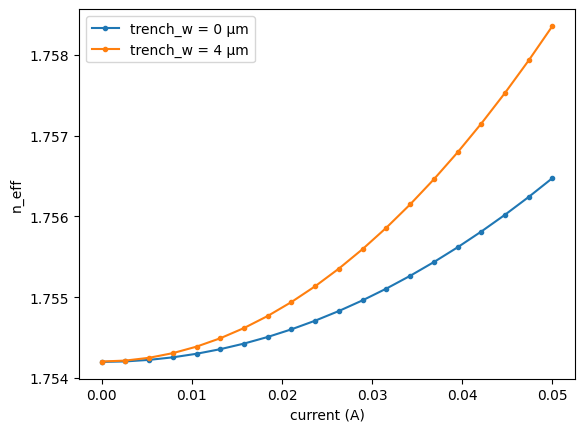

In [3]:

plt.figure()
for w in [0, 4]:
    currents = np.linspace(0.0, 50e-3, 20)
    n_eff = simulate_heater(currents=currents, trench_w=w)

    plt.plot(currents, n_eff, ".-", label=f"trench_w = {w} µm")
plt.legend()
plt.xlabel("current (A)")
plt.ylabel("n_eff")
